In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
os.chdir('src')
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.style.use('./presentation.mplstyle')
import matplotlib.transforms as transforms
import pandas as pd
from datetime import datetime, timedelta

from solvers import *
from plot import *

In [2]:
def getMetaData(region = "India"):
    popDict = {"India": 1366417755, "Netherlands": 17097123, "Mexico": 127575528, "Mumbai": 20411000}
    underreporting_factor = {"India": 25.28686435, "Netherlands": 2.8345572, "Mexico": 43.12753953, "Mumbai": 18.86570445}
    bedsPerCapita = {"India": 0.53/1000, "Netherlands": 3.32/1000, "Mexico": 1.38/1000, "Mumbai": 0.53/1000} 
    hospToReported = {"India": 0.5, "Netherlands": 0.2, "Mexico": 0.9, "Mumbai": 0.5}
    h = {"India": 1./50, "Netherlands": 1./15, "Mexico": 1./50, "Mumbai": 1./50}
    regionType = {"India": "country", "Netherlands": "country", "Mexico": "country", "Mumbai": "district"} 
    return {"region": region, "population": popDict[region], "underreporting_factor": underreporting_factor[region],
           "bedsPerCapita": bedsPerCapita[region], "hospToReported": hospToReported[region], "region_type": regionType[region], "h":h[region]}   

In [3]:
def moving_average(x, window):
    l = len(x)
    w = int((window-1)/2)
    x1 = [np.mean(x[max(0, i-w):min(l, i+w+1)]) for i in range(l)]
    return np.array(x1)


In [4]:
meta = getMetaData("India") 

if(meta['region_type'] == 'country'):
    df = pd.read_csv('../data/time_series_covid19_confirmed_global_tillDec.csv')
    df = df.drop(['Lat', 'Long'], axis =1)
    df = df.groupby('Country/Region').agg('sum')
    df = df.loc[meta['region']][98:-3]
    start_date = datetime.strptime(df.index[0], "%m/%d/%y")
    print(start_date)
    print(df.head(1))
    print(df.tail(1))

    dfrec = pd.read_csv('../data/time_series_covid19_recovered_global_tillDec.csv')
    dfrec = dfrec.drop(['Lat', 'Long'], axis =1)
    dfrec = dfrec.groupby('Country/Region').agg('sum')
    dfrec = dfrec.loc[meta['region']][98:-3]
    print(dfrec.head(1))
    print(dfrec.tail(1))
    
    dfdeceased = pd.read_csv('../data/time_series_covid19_deaths_global_tillDec.csv')
    dfdeceased = dfdeceased.drop(['Lat', 'Long'], axis =1)
    dfdeceased = dfdeceased.groupby('Country/Region').agg('sum')
    dfdeceased = dfdeceased.loc[meta['region']][98:-3]
    print(dfdeceased.head(1))
    print(dfdeceased.tail(1))

    Rec_real = np.array(list(dfrec))
    Conf_real = np.array(list(df))
    Deceased_real = np.array(list(dfdeceased))
    
elif(meta['region_type'] == 'district'):
    df = pd.read_csv('../data/districts.csv')
    df = df[df['District'] == meta['region']]
    start_date = datetime.strptime(df.iloc[3]['Date'], "%Y-%m-%d")
    print(start_date)
    Rec_real = np.array(df.iloc[3:-4]['Recovered'])
    Conf_real = np.array(df.iloc[3:-4]['Confirmed'])
    Deceased_real = np.array(df.iloc[3:-4]['Deceased'])
    print(df.iloc[3])
    print(df.iloc[-5])
    
print(start_date)

if(meta['region'] == 'Mumbai'): # Fixing Data Issue - Confirmed cases went down on 16th December which is not possible
    Conf_real[-14:] = Conf_real[-14:] + Conf_real[-15] - Conf_real[-14]
    Rec_real[-14:] = Rec_real[-14:] + Rec_real[-15] - Rec_real[-14]
    Deceased_real[-12:] = Deceased_real[-12:] + Deceased_real[-13] - Deceased_real[-12]
    
    
deltaI_real_before_average = np.array([Conf_real[i] - Conf_real[i-1] for i in range(1, len(Conf_real))])
I_real_before_average = Conf_real - Rec_real - Deceased_real

deltaI_real = moving_average(deltaI_real_before_average, 5)
I_real = moving_average(I_real_before_average, 5)

2020-04-29 00:00:00
4/29/20    33062
Name: India, dtype: int64
12/29/20    10244852
Name: India, dtype: int64
4/29/20    8437
Name: India, dtype: int64
12/29/20    9834141
Name: India, dtype: int64
4/29/20    1079
Name: India, dtype: int64
12/29/20    148439
Name: India, dtype: int64
2020-04-29 00:00:00


In [5]:
N = meta['population']
p = meta['bedsPerCapita']
underreporting_factor = meta['underreporting_factor']
reporting_percentage = 1/underreporting_factor
h = meta['h']

d = 20 #T_hosp
gamma = 1/5.


Istar = 0.76*N*p/(h*gamma*d)
deltaHstar = Istar*h*gamma
print("*****", deltaHstar)
print(Istar)
print("Istar = N/{}".format(str(N/Istar)))
R0 = Rec_real[0]
r = 4.2
e = r/Istar

I0 = deltaI_real[0]*underreporting_factor/gamma
S0 = N - I0 - R0
beta0 = gamma*N/S0

Jstar = gamma*N
init = (S0, I0, R0)

delta_t = 0.001
tsteps = 350
t = np.linspace(0, tsteps-1, tsteps)
eta = 5
print("r:{}, e:{}, beta0:{}, Istar:{}, S0:{}, I0:{}, R0:{}".format(r, e, beta0,  Istar, S0, I0, R0))

***** 27519.653585699998
6879913.396424999
Istar = N/198.60973187686199
r:4.2, e:6.104728007452013e-07, beta0:0.20004218514316996, Istar:6879913.396424999, S0:1366129603.135515, I0:279714.8644849166, R0:8437


In [6]:
dates = [start_date + timedelta(i) for i in range(tsteps)]

In [7]:
xticks_idx = []
xticks = []
for i, date in enumerate(dates):
    if(date.day == 1):
        xticks_idx.append(i)
        xticks.append("{}'{}".format(datetime.strftime(date, "%b"), datetime.strftime(date, "%y")))

In [8]:
deltaI_real_c = deltaI_real*underreporting_factor
I_real_c = I_real*underreporting_factor

In [9]:
R_intervention_h = 0.8
R_intervention_l = 0.5
beta_intervention_h = R_intervention_h*gamma
beta_intervention_l = R_intervention_l*gamma
R_relaxation = 2.2
beta_relaxation = R_relaxation*gamma
beta_dI_h = []
beta_dI_l = []
T_intervention = 60
T_relaxation = 30
temp = 0
while temp < tsteps:
    if(temp+T_intervention>=tsteps):
        beta_dI_h.extend([beta_intervention_h for i in range(tsteps - temp)])
        beta_dI_l.extend([beta_intervention_l for i in range(tsteps - temp)])
        temp += tsteps - temp
    else:
        beta_dI_h.extend([beta_intervention_h for i in range(T_intervention)])
        beta_dI_l.extend([beta_intervention_l for i in range(T_intervention)])
        beta_dI_h.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))]) 
        beta_dI_l.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))])
        temp += T_intervention + min(T_relaxation, tsteps - temp)
beta_dI_h = np.array(beta_dI_h)[:tsteps]
beta_dI_l = np.array(beta_dI_l)[:tsteps]

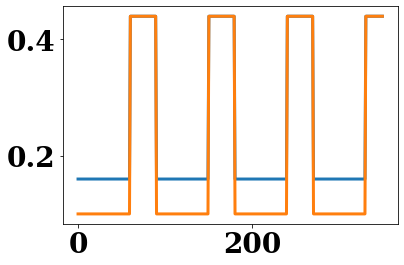

In [10]:
plt.plot(t, beta_dI_h)
plt.plot(t, beta_dI_l)

In [11]:
S_dI_h, I_dI_h, R_dI_h = solve_discrete_sir((S0, I0, R0), beta_dI_h, gamma, N, tsteps, delta_t=delta_t)
S_dI_l, I_dI_l, R_dI_l = solve_discrete_sir((S0, I0, R0), beta_dI_l, gamma, N, tsteps, delta_t=delta_t)

beta_cons = 2.2*gamma
S_cons, I_cons, R_cons = solve_discrete_sir((S0, I0, R0), beta_cons, gamma, N, tsteps, delta_t=delta_t)

In [12]:
def find_approximation(beta, klevels, loss_function):
    """
        Find the best approximation of beta (m,) sized array
        based on one of the klevels (k,) sized array. The
        goodness of approximation is based on 

        loss_function: (y, y_hat) -> R (positive reals)

        Returns: beta_approx (m,) sized array
        such that: 
            
            \sum_t loss_function(beta_approx(t), beta(t))
        i.e. pointwise loss values are minimized.

        Since, loss_function is positive and pointwise,
        elementwise minimum should minimise the global objective.

        TODO: Should we impose some sort of smoothness constraint
        on beta_approx(t) ?
    """
    num_steps = np.shape(beta)[0]
    num_levels = np.shape(klevels)[0]
    
    #TODO: Try out a vectorized implementation
    beta_approx = []
    for t in range(num_steps):
        beta_val = beta[t]
        losses = loss_function(beta_val, klevels)
        best_beta = klevels[np.argmin(losses)]
        beta_approx.append(best_beta)

    beta_approx = np.array(beta_approx)
    return beta_approx

In [13]:
S_ideal, I_ideal, R_ideal, beta_ideal = solve_sir_lv_control(S0, I0, R0, beta0, N, r, e, gamma, eta, t)

In [14]:
klevels = np.array([0.05*i for i in range(2,12)])
print(klevels)
loss_function = lambda x,y: (x-y)**2
beta_approx = find_approximation(beta_ideal, klevels, loss_function)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]


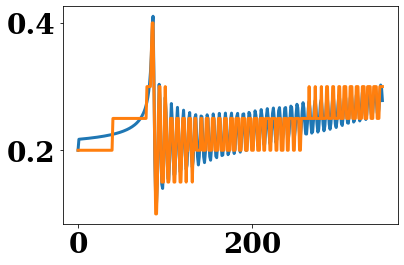

In [15]:
x = len(beta_ideal)
plt.plot(range(len(beta_ideal[:x])), beta_ideal[:x])
plt.plot(range(len(beta_ideal[:x])), beta_approx[:x])

In [16]:
S_approx, I_approx, R_approx = solve_discrete_sir((S0, I0, R0), beta_approx, gamma, N, tsteps, delta_t=delta_t)

In [17]:
xticks_new = []

for i, xtick in enumerate(xticks):
    if(i%2 == 0):
        xticks_new.append('')
    else:
        xticks_new.append(xtick)
        
xticks_new

['',
 "Jun'20",
 '',
 "Aug'20",
 '',
 "Oct'20",
 '',
 "Dec'20",
 '',
 "Feb'21",
 '',
 "Apr'21"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


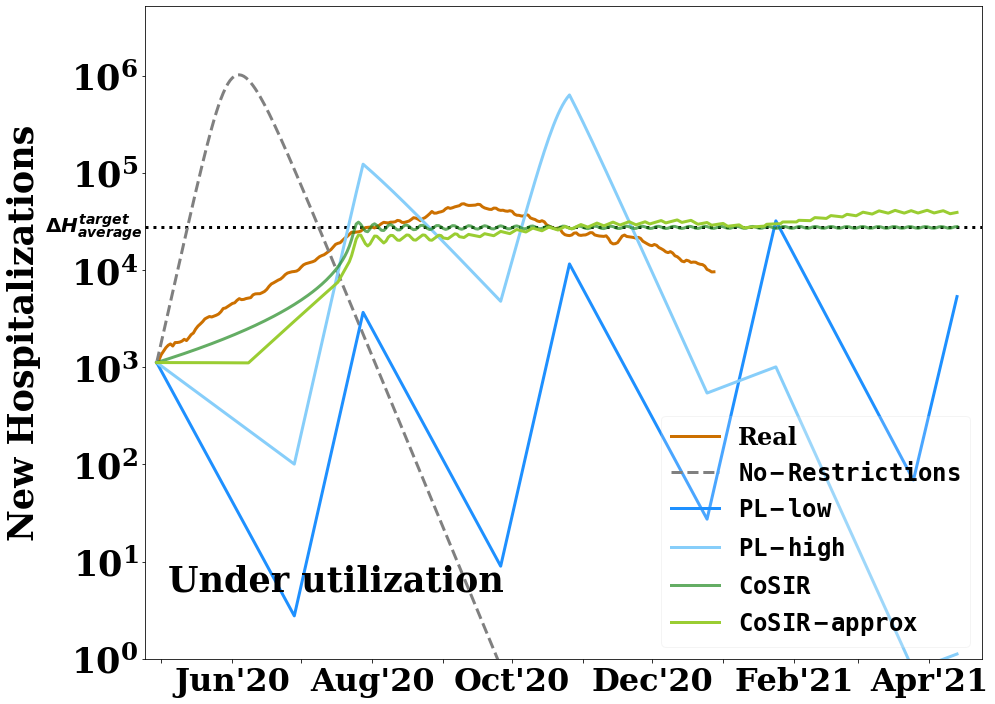

In [18]:
fig, ax = plt.subplots(figsize=(15,12))
plt.yscale('log')
plt.ylim(top=np.max(I_cons*h)*1.01, bottom=1)
plt.xlim(-5, tsteps+10)
plt.tick_params(axis='y', which='minor', left=False, right=False)


plt.hlines(y=deltaHstar, xmin=-5, xmax=tsteps+10, linestyles='dotted')


trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0.005, deltaHstar+100, r'$\Delta H^{target}_{average}$', color="black", transform=trans, ha="right", va="center", fontsize=20)

trans = transforms.blended_transform_factory(ax.get_xticklabels()[0].get_transform(), ax.transData)

ax.plot(range(len(deltaI_real)), deltaI_real_c*h, '-', label='Real', color='#cc7000')

ax.plot(t, I_cons*gamma*h, label=r'$\mathtt{No-Restrictions}$', ls='--', color='grey')

ax.plot(t, I_dI_l*gamma*h, label=r'$\mathtt{PL-low}$', color='dodgerblue')
ax.plot(t, I_dI_h*gamma*h, label=r'$\mathtt{PL-high}$', color='lightskyblue')

ax.plot(t, I_ideal*gamma*h, '-', alpha=0.7, label=r'$\mathtt{CoSIR}$', color='forestgreen')
ax.plot(t, I_approx*gamma*h, '-', label=r'$\mathtt{CoSIR-approx}$', color='yellowgreen')
plt.legend(loc='lower right', fontsize=24, framealpha=0.2)
plt.xticks(xticks_idx, xticks_new, rotation = 0, fontsize=32)
plt.ylabel("New Hospitalizations", fontweight='bold', labelpad = 30, fontsize=35)
plt.yticks(fontsize=35)
plt.text(s = "Under utilization", x=5, y=5, fontsize=35)   # Netherlands
# plt.text(s = "Excess demand", x=75, y=100000, fontsize=35) # India

plt.savefig('../figures/experiments2/{}_deltaHcasecounts.eps'.format(meta['region']), format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


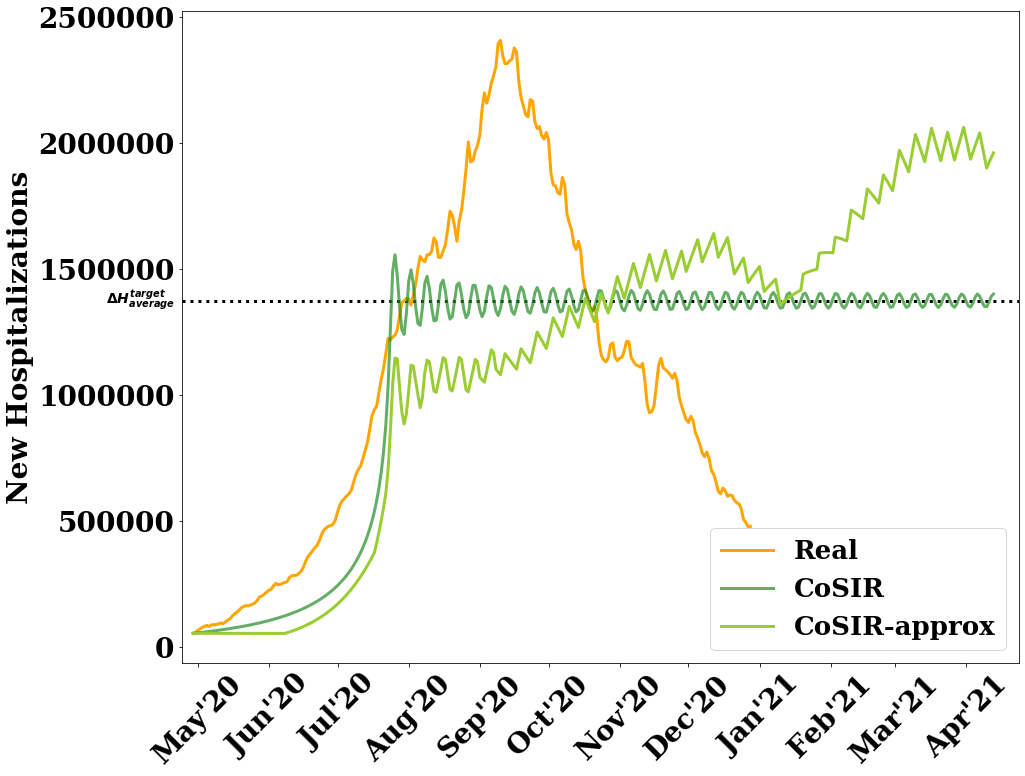

In [19]:
fig, ax = plt.subplots(figsize=(15,12))
# plt.yscale('log')
# plt.ylim(top=np.max(I_cons)*1.01, bottom=1)
plt.xlim(-5, tsteps+10)
plt.tick_params(axis='y', which='minor', left=False, right=False)


plt.hlines(y=Istar*gamma, xmin=-5, xmax=tsteps+10, linestyles='dotted')
# plt.axvline(x=len(deltaI_real), ls=':', color='black')

trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, Istar*gamma+1000, r'$\Delta H^{target}_{average}$', color="black", transform=trans, ha="right", va="center", fontsize=14)

trans = transforms.blended_transform_factory(ax.get_xticklabels()[0].get_transform(), ax.transData)

ax.plot(range(len(deltaI_real)), deltaI_real_c, '-', label='Real', color='orange')

# ax.plot(t, I_cons*gamma, label=r'Constant $\beta$', ls='--', color='grey')

# ax.plot(t, I_dI_l*gamma, label='DI_low', color='dodgerblue')
# ax.plot(t, I_dI_h*gamma, label='DI_high', color='lightskyblue')

ax.plot(t, I_ideal*gamma, '-', alpha=0.7, label='CoSIR', color='forestgreen')
ax.plot(t, I_approx*gamma, '-', label='CoSIR-approx', color='yellowgreen')
# plt.grid()
plt.legend()
plt.xticks(xticks_idx, xticks, rotation = 45)
plt.ylabel("New Hospitalizations", fontweight='bold')
# plt.xlabel("Time", fontweight='bold')
# plt.title(meta['region'], fontsize = 32, fontweight = 'bold')
plt.savefig('../figures/experiments2/{}_deltaIcasecounts_linear.eps'.format(meta['region']), format='eps')

In [20]:
def getControlMetrics(I, Istar):
    c = 0
    for idx, i in enumerate(I):
        c += np.abs(i-Istar)/Istar
    return c/len(I)

l = len(I_real)
# print("Till Current t")
print("Constant beta: {:.3f}".format(getControlMetrics(I_cons[:l]*gamma, Istar*gamma)))
print("Real: {:.3f}".format(getControlMetrics(deltaI_real*underreporting_factor, Istar*gamma)))
print("Dynamic Intervention R=0.8: {:.3f}".format(getControlMetrics(I_dI_h[:l]*gamma, Istar*gamma)))
print("Dynamic Intervention R=0.5: {:.3f}".format(getControlMetrics(I_dI_l[:l]*gamma, Istar*gamma)))
print("Ideal beta: {:.3f}".format(getControlMetrics(I_ideal[:l]*gamma, Istar*gamma)))
print("Approx beta: {:.3f}".format(getControlMetrics(I_approx[:l]*gamma, Istar*gamma)))


Constant beta: 3.857
Real: 0.465
Dynamic Intervention R=0.8: 2.074
Dynamic Intervention R=0.5: 0.966
Ideal beta: 0.315
Approx beta: 0.403


In [21]:
def getIBelowAboveIstar(I, Istar):
    below = 0
    above = 0
    for i in I:
        if(i<=Istar):
            below+=Istar-i
        else:
            above+=i-Istar
    return below/(len(I)*Istar), above/(len(I)*Istar)


{'Real': (0.3479253305125432, 0.11704817829011252), 'No Restrictions': (0.802979684955195, 2.197109427836593), 'PL_high': (0.6658284095771567, 1.083167632665654), 'PL_low': (0.927420946743761, 0.0006378041973224405), 'Ideal': (0.2164416528162689, 0.008323754516724227), 'Approx': (0.26389558019619935, 0.09927961577288855)}


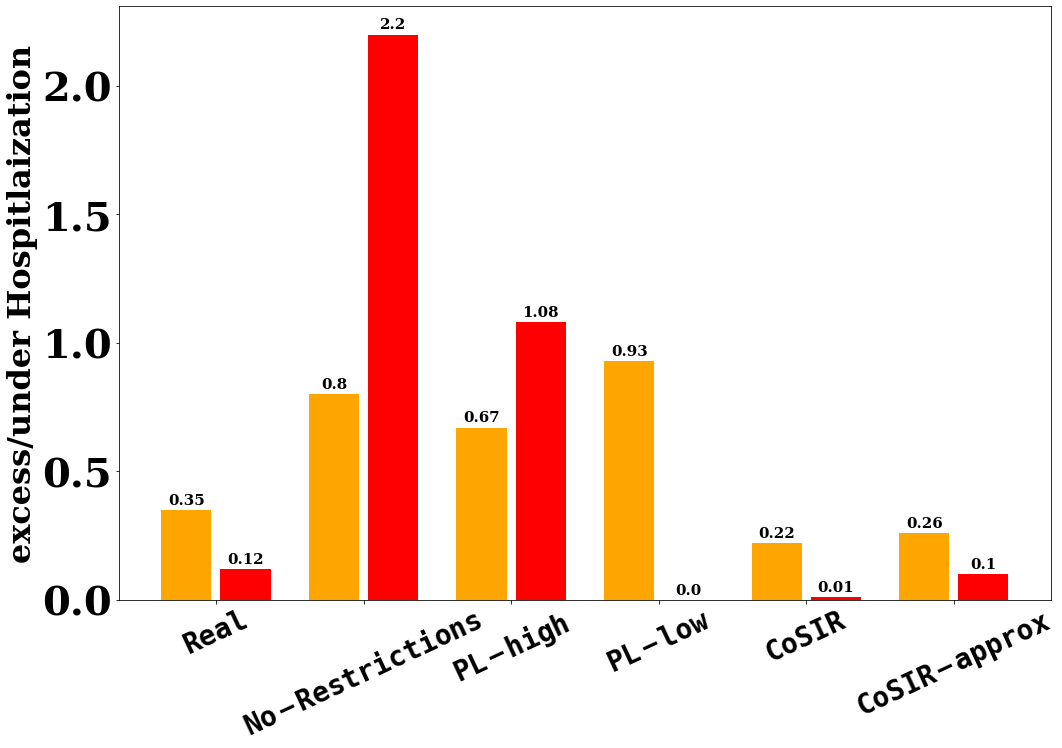

In [22]:
belowAbove = {}
belowAbove['Real'] = getIBelowAboveIstar(deltaI_real_c*h, deltaHstar)
belowAbove['No Restrictions'] = getIBelowAboveIstar(I_cons*gamma*h, deltaHstar)
belowAbove['PL_high'] = getIBelowAboveIstar(I_dI_h*gamma*h, deltaHstar)
belowAbove['PL_low'] = getIBelowAboveIstar(I_dI_l*gamma*h, deltaHstar)
belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal*gamma*h, deltaHstar)
belowAbove['Approx'] = getIBelowAboveIstar(I_approx*gamma*h, deltaHstar)
print(belowAbove)
names = ['Real', 'No Restrictions', 'PL_high', 'PL_low', 'Ideal', 'Approx']
belows = [round(belowAbove[n][0], 2) for n in names]
aboves = [round(belowAbove[n][1], 2) for n in names]


labels = [r'$\mathtt{Real}$', r'$\mathtt{No-Restrictions}$', r'$\mathtt{PL-high}$', r'$\mathtt{PL-low}$', r'$\mathtt{CoSIR}$', r'$\mathtt{CoSIR-approx}$']


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10.5))
rects1 = ax.bar(x/2 - width/2, belows, width*0.85, label=r'Under Hospitlaization', color = 'orange')
rects2 = ax.bar(x/2 + width/2, aboves, width*0.85, label=r'Excess Hospitalization', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('excess/under Hospitlaization',  fontweight = 'bold', fontsize = 32)
# ax.set_xlabel('Control Method',  fontweight = 'bold')
ax.set_xticks(x/2)
ax.set_xticklabels(labels, rotation=25)
# ax.legend(fontsize = 35)
ax.tick_params(axis='y', labelsize=40)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('../figures/experiments2/{}_deltaHcontrolMetrics.eps'.format(meta['region']), format = 'eps')

In [23]:
def betaTrend(betaList):
    below = []
    above = []
    minBeta = 0
    x = [minBeta + float(i)/200 for i in range(91)]
    for b in x:
        tempbelow = 0
        tempabove = 0
        for beta in betaList:
            if(float(beta)<=b):
                tempbelow+=1
            else:
                tempabove+=1
        below.append(tempbelow)
        above.append(tempabove)
    return below, above, x
                

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


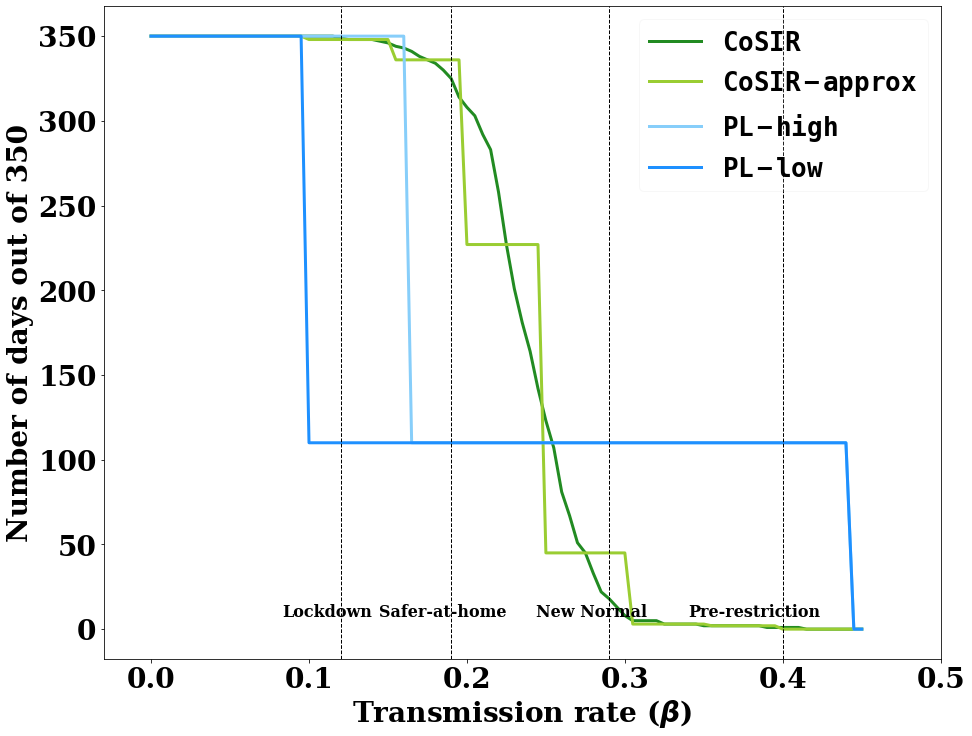

In [24]:
fig, ax = plt.subplots(figsize=(15,12))
b, a, x = betaTrend(beta_ideal)
ax.plot(x, a, label=r'$\mathtt{CoSIR}$', color='forestgreen')
b, a, x = betaTrend(beta_approx)
ax.plot(x, a, label = r'$\mathtt{CoSIR-approx}$', color='yellowgreen')
b, a, x = betaTrend(beta_dI_h)
plt.plot(x, a, label = r'$\mathtt{PL-high}$', color='lightskyblue')
b, a, x = betaTrend(beta_dI_l)
ax.plot(x, a, label = r'$\mathtt{PL-low}$', color='dodgerblue')
plt.xlim(-0.03, 0.5)
plt.axvline(x = 0.12, ls = '--', lw = 1, color = 'black')
# plt.axvline(x = 0.14, ls = '--', lw = 1, color = 'black')
plt.axvline(x = 0.19, ls = '--', lw = 1, color = 'black')
plt.axvline(x = 0.29, ls = '--', lw = 1, color = 'black')
plt.axvline(x = 0.4, ls = '--', lw = 1, color = 'black')
plt.text(x=0.4+0.024, y=10, s='Pre-restriction', color="black", ha="right", va="center", fontsize=16)
plt.text(x=0.12+0.02, y=10, s='Lockdown', color="black", ha="right", va="center", fontsize=16)
# plt.text(x=0.14+0.035, y=40, s='Stay-at-home', color="black", ha="right", va="center", fontsize=14)
plt.text(x=0.19+0.035, y=10, s='Safer-at-home', color="black", ha="right", va="center", fontsize=16)
plt.text(x=0.29+0.024, y=10, s='New Normal', color="black", ha="right", va="center", fontsize=16)
plt.legend(framealpha=0.15)

# plt.grid(alpha = 0.4)
plt.xlabel(r"Transmission rate ($\beta$)",  fontweight='bold')
plt.ylabel(r"Number of days out of 350",  fontweight='bold')
# plt.title(meta['region'], fontsize = 32, fontweight = 'bold')
plt.savefig('../figures/experiments2/{}_visualisestrictness.eps'.format(meta['region']), format = 'eps')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

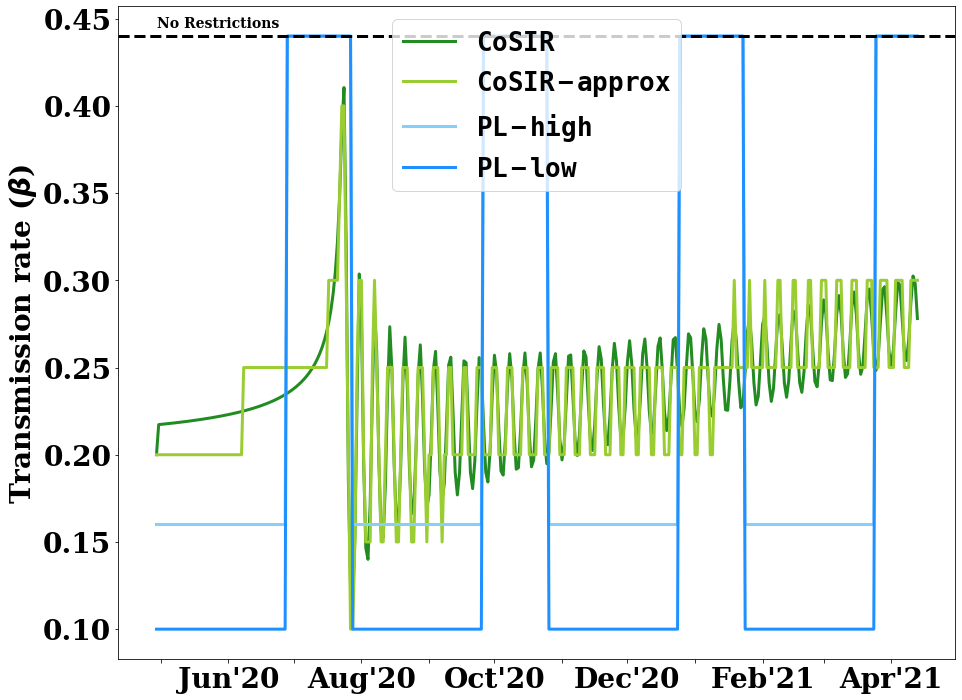

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize=(15,12))
l = len(beta_ideal)
plt.plot(range(l), beta_ideal, label=r'$\mathtt{CoSIR}$', color='forestgreen')
plt.plot(range(l), beta_approx, label=r'$\mathtt{CoSIR-approx}$', color='yellowgreen')
plt.plot(range(l), beta_dI_h, label=r'$\mathtt{PL-high}$', color='lightskyblue')
plt.plot(range(l), beta_dI_l, label=r'$\mathtt{PL-low}$', color='dodgerblue')
plt.legend()
plt.axhline(y=0.44, ls='--', color='black')
ax.text(0.007, 0.445, s='No Restrictions', color="black", fontsize=14)
plt.xticks(xticks_idx, xticks_new,  rotation = 0)
# plt.xlabel("Time", fontweight = 'bold')
plt.ylabel(r"Transmission rate ($\beta$)", fontweight = 'bold')
plt.savefig('../figures/experiments2/{}_beta.eps'.format(meta['region']),  format = 'eps')

# LV Energy for various methods

In [26]:
def compute_w_series(beta, S, I, gamma, N, r, e):
    Jstar = gamma*N
    Istar = r/e
    W = []
    for t in range(len(beta)):
        W.append(beta[t]*S[t]/N - gamma*np.log(beta[t]*S[t]/Jstar) + e*I[t] - r*np.log(I[t]/Istar))
    return W

In [27]:
w_ideal = compute_w_series(beta_ideal, S_ideal, I_ideal, gamma, N, r, e)
w_approx = compute_w_series(beta_approx, S_approx, I_approx, gamma, N, r, e)
w_dI_h = compute_w_series(beta_dI_h, S_dI_h, I_dI_h, gamma, N, r, e)
w_dI_l = compute_w_series(beta_dI_l, S_dI_l, I_dI_l, gamma, N, r, e)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

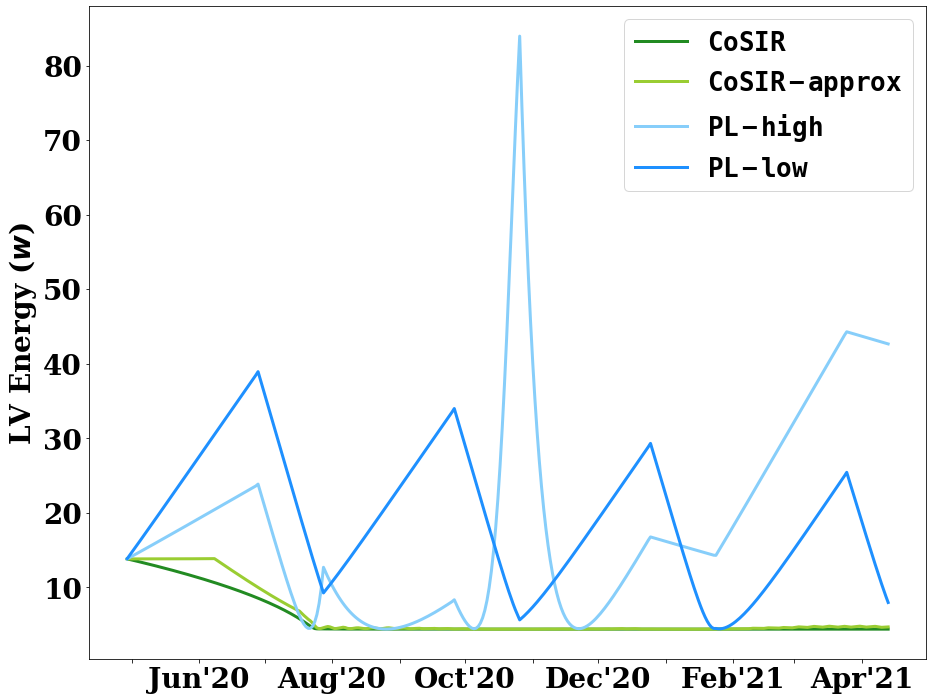

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(range(len(w_ideal)), w_ideal, label=r'$\mathtt{CoSIR}$', color='forestgreen')
plt.plot(range(len(w_ideal)), w_approx, label=r'$\mathtt{CoSIR-approx}$', color='yellowgreen')
plt.plot(range(len(w_ideal)), w_dI_h, label=r'$\mathtt{PL-high}$', color='lightskyblue')
plt.plot(range(len(w_ideal)), w_dI_l, label=r'$\mathtt{PL-low}$', color='dodgerblue')
plt.legend()
plt.xticks(xticks_idx, xticks_new,  rotation = 0)
# plt.xlabel("Time", fontweight = 'bold')
plt.ylabel(r"LV Energy ($w$)", fontweight = 'bold')
plt.savefig('../figures/experiments2/{}_w_wrt_time.eps'.format(meta['region']),  format = 'eps')

# Example for practical implementation feasibility - India

<Figure size 432x288 with 0 Axes>

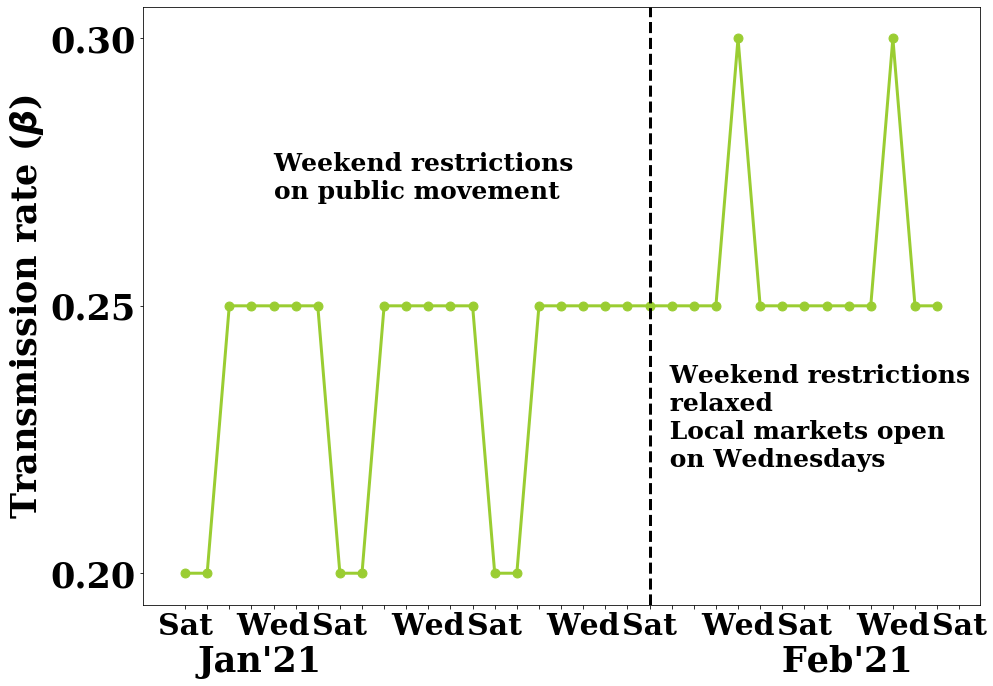

In [27]:
start = 240
end = 275

ticksIdx = range(end-start+1)
ticksWeek = ['Sat', '', '', '', 'Wed', '', '']
ticksLabel = []
while(len(ticksLabel)<len(ticksIdx)):
    ticksLabel.extend(ticksWeek)
plt.clf()
fig, ax = plt.subplots(figsize=(15, 11))
l = len(beta_ideal[start:end])
plt.plot(range(l), beta_approx[start:end], label=r'$\mathtt{CoSIR-approx}$', color='yellowgreen')
plt.scatter(range(l), beta_approx[start:end], label=r'$\mathtt{CoSIR-approx}$', color='yellowgreen', s=80)

# plt.axvline(x=0, ls='--', color='black')
ax.text(x=4, y=0.27, s='Weekend restrictions \non public movement', color="black", fontsize=25)

plt.axvline(x=21, ls='--', color='black')
ax.text(x=21.5, y=0.22, s=' Weekend restrictions \n relaxed\n Local markets open \n on Wednesdays', color="black", fontsize=25)
plt.xticks(ticksIdx, ticksLabel,  rotation = 0, fontsize=30)
plt.yticks([0.2, 0.25, 0.3], fontsize=35)
plt.ylabel(r"Transmission rate ($\beta$)", fontweight = 'bold', fontsize=35)
plt.xlabel("Jan'21                                      Feb'21 ", fontweight = 'bold', fontsize=35)
plt.savefig('../figures/experiments2/{}_beta_practicalExample.eps'.format(meta['region']),  format = 'eps')